In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
import os 
from datetime import datetime
import time

service = Service(executable_path = ChromeDriverManager().install())
browser = webdriver.Chrome(service=service)

# implicit wait 
browser.implicitly_wait(5) # 로딩될 때까지 최대 5초 대기 
browser.maximize_window()

# 유튜브 영상 사이트로 이동
browser.get('https://www.youtube.com/watch?v=kW_z-NMuZIU') # 호주전
# browser.get("https://www.youtube.com/watch?v=FBynfiRGdlc") # 사우디전
time.sleep(5)

# 현재 페이지의 높이 조회 -> javascript***
scroll_pane_height = browser.execute_script("return document.documentElement.scrollHeight") 
# 댓글창 로딩될 만큼 스크롤 내리기
browser.execute_script("window.scrollTo(0, document.documentElement.scrollHeight * 0.1)")
time.sleep(2)

# 댓글 리스트 
comment_list=[]

# while True:
cnt = 0
while True:
    # 스크롤 내리기
    browser.execute_script("window.scrollTo(0, document.documentElement.scrollHeight)")
    # 이동 후 height 를 조회
    time.sleep(2)
    new_scroll_pane_height = browser.execute_script(
        "return document.documentElement.scrollHeight"
    )
    # 이전 높이와 이동 후 높이가 같다면 
    if scroll_pane_height == new_scroll_pane_height: 
        break
    scroll_pane_height = new_scroll_pane_height
    cnt += 1



# 조회 (크롤링)
comments_tag = browser.find_elements(By.CSS_SELECTOR,"#content-text > span") # css selector
for tag in comments_tag:  
    comment_list.append(tag.text.strip())

browser.close()


# 크롤링한 댓글 파일 저장 
os.makedirs("comments",exist_ok=True)
d = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
file_name = f'comments/comments_{d}.txt'

with open(file_name, 'wt',encoding='utf-8') as file:
    file.write('.'.join(comment_list))



In [2]:
# 텍스트 전처리 
import re
import konlpy
from konlpy.tag import Okt

txt_path = r"C:\classes\06_NLP_Preprocessing\project\comments\comments_2024-04-24-18-26-35.txt"

with open(txt_path, "rt",encoding="utf-8") as fd:
    comments= fd.read()

# 엔터는 띄어쓰기로 바꾸기
comments = re.sub(r"\n", " ", comments)
# 특수문자, 숫자, 이모티콘 제거 
comments = re.sub(r"[^a-zA-Z가-힣 ]", "", comments) # 패턴, 바꿀 문자열, string
comments[:200]

'아시아 역사상 최고의 선수 손흥민근데 황희찬 진짜 미친 강심장이다 저기서 본인이 나서서 실패하면 엄청 욕먹을거 알면서도 자신 있다고 하고 저렇게 깔끔하게 성공 씨찬이 다시 봤음 더 크게 되길조현우 칭찬해줘라 진짜조현우도 최고다 사실 막아주는 것도 매우 중여하다고 생각함  모두 잘해줬다 정말이번 아시안컵 최대 빌런은 대한민국임  상대팀 행복회로 다 돌려놓고 '

In [3]:
# 토큰화 및 품사부착 (Okt)
okt = Okt()
okt_tokens = okt.pos(comments, stem = True) #원형복원 # 비속어 처리 


# 명사 동사만추출
comm_tokens = [word for word, pos in okt_tokens if pos in ['Verb','Noun','Adjective']] # 명사만 추출할 시 Noun쓰면 됨
comm_tokens[:10]

['아시아', '역사상', '최고', '선수', '손흥민', '황희찬', '진짜', '미치다', '강심장', '저기']

In [4]:
# 불용어 사전을 만들어서 불용어 제거
f = open(r'C:\classes\06_NLP_Preprocessing\project\stopword.txt',"rt", encoding = "utf-8")
stopwords = f.read().split("\n")
result = [word for word in comm_tokens if not word in stopwords]
print(len(result))


12017


In [20]:
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [372]:
###########
# wordpiece tokenizer
import os
from tokenizers import Tokenizer # 클래스 
from tokenizers.models import WordPiece
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer,BpeTrainer
import time

os.makedirs("saved_models",exist_ok=True)

path = 'C:\classes\06_NLP_Preprocessing\project\comments\comments_2024-04-24-18-26-35.txt'
# 토크나이저 알고리즘 객체를 넣어서 tokenizer 생성
wp_tokenizer = Tokenizer(WordPiece()) # unk가 디폴트 

# Pre tokenizer 설정 (1차 토큰화 작업 단위)
wp_tokenizer.pre_tokenizer = Whitespace() #공백 기준
# Trainer 생성 -> 어휘사전 어떻게 만들지 설정. 어떻게 학습할지 
trainer = WordPieceTrainer(vocab_size = 20000, special_tokens=['[UNK]']) # training 할 때 없었던 단어에는 unk주기



In [5]:

# 학습 -> 50000줄씩 끊어서 학습 (양이 많을 때 쪼개서 학습)
batch_size = 50_000 # 몇 라인 단위로 학습시킬지
current_batch = [] # 학습시킬 문자열들을 담은 리스트 
text_path = r'C:\classes\06_NLP_Preprocessing\project\comments\comments_2024-04-24-18-26-35.txt'
with open(text_path, 'rt', encoding='utf-8') as fr: #fr : iterable 한줄씩 
    s = time.time()
    # batch_size 줄 만큼 current_batch에 저장 
    for line in fr:
        current_batch.append(line)
        if len(current_batch) == batch_size: # batch size만큼(50000줄) 다 읽었으면
            # 학습
            wp_tokenizer.train_from_iterator(current_batch, trainer)
            # 리스트 비우기  #50000개씩 학습시키면서, 비우기 밙반복
            current_batch.clear() 
    # current_batch에 있는 나머지 데이터 학습 (50000개 딱 안떨어짐)
    wp_tokenizer.train_from_iterator(current_batch, trainer)
            
    e = time.time()
print(f"걸린시간: {e-s}초") 


# 저장
saved_path = "saved_models/comments_wordpiece.json"
wp_tokenizer.save(saved_path)

걸린시간: 0.08740401268005371초


In [9]:
# 저장된 model을 loading
saved_tokenizer = Tokenizer.from_file(saved_path)

# 토큰화
output = saved_tokenizer.encode(comments)

# 토큰들
output.tokens # subword : ##서브워드 표시
# output.tokens[:10]

['[UNK]']

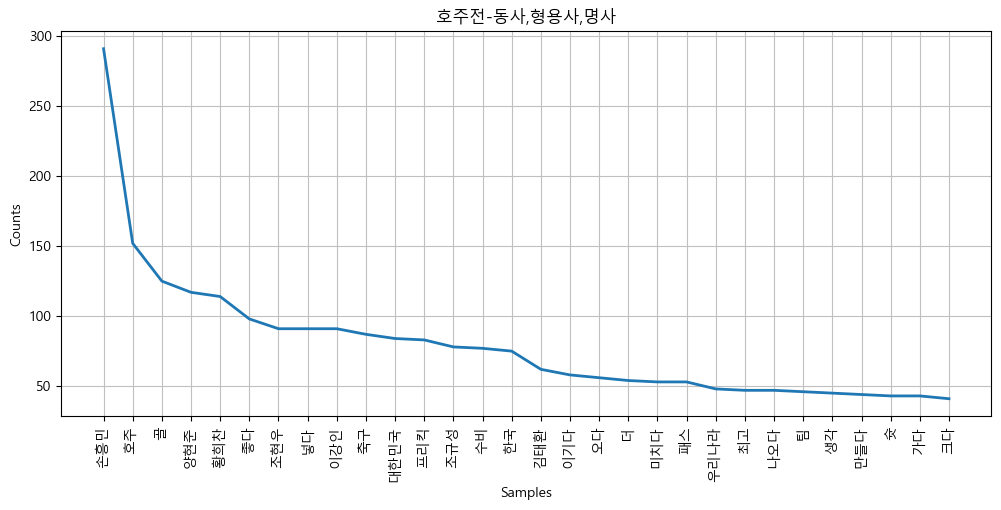

In [5]:
# Text 분석
from nltk import Text
text = Text(result, name = "호주전")

# 빈도수 선 그래프 시각화
import matplotlib.pyplot as plt

#한글 설정
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12,5))  # 선그래프 가로로 길게
plt.title('호주전-동사,형용사,명사')
text.plot(30)
plt.show()


In [6]:
### 빈도수 관련 분석
fd = text.vocab()

print("고유 토큰 개수:",fd.B())
print('총 토큰 수:', fd.N())
print('가장 많이 나온 토큰:', fd.max())
print('손흥민의 빈도수:', fd.get('손흥민')) 
print('황희찬의 빈도수:', fd.get('황희찬'))
print('이강인의 빈도수:', fd.get('이강인'))
print(f"클리스만(감독)의 빈도수: {fd.get('클리스만')+fd.get('감독')}") 
print(f'가장 많이 나온 토큰({fd.max()})의 빈도수: {fd.get(fd.max())}')
print(f"가장 많이 나온 토큰의 총 토큰수 대비 비율: {fd.freq(fd.max())* 100:.2f}%")

고유 토큰 개수: 2964
총 토큰 수: 12017
가장 많이 나온 토큰: 손흥민
손흥민의 빈도수: 291
황희찬의 빈도수: 114
이강인의 빈도수: 91
클리스만(감독)의 빈도수: 44
가장 많이 나온 토큰(손흥민)의 빈도수: 291
가장 많이 나온 토큰의 총 토큰수 대비 비율: 2.42%


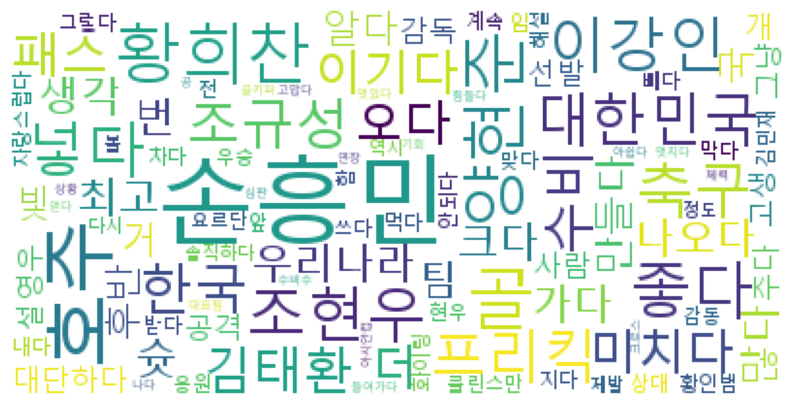

In [7]:
import os 
from datetime import datetime

## WordCloud
from wordcloud import WordCloud

wc = WordCloud(
    font_path = r"c:\Winddows\Fonts\malgun.ttf",
    max_words = 100,
    min_font_size = 1,
    max_font_size = 50,
    relative_scaling = 0.5, 
    background_color= "white"
)
# 파일 저장 
# 출력 이미지 
word_cloud_img = wc.generate_from_frequencies(fd)

d = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


os.makedirs("wordcloud",exist_ok=True)
wc.to_file(f"wordcloud/aus_wc_{d}.png")

plt.figure(figsize= (10,10))
plt.axis("off")
plt.imshow(word_cloud_img)

In [12]:
# TF-IDF 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 불용어 리스트 불러오기
with open(r"C:\classes\06_NLP_Preprocessing\project\stopword.txt", "rt", encoding='utf-8') as f:
    stopwords=f.read().split()

# Okt 토크나이저 함수 정의
okt = Okt()
def okt_tokenizer(text):
    tokens = okt.morphs(text, stem=True)
    # tokens = okt.pos(text, stem=True)
    return [token for token in tokens if token not in stopwords]


tfidf = TfidfVectorizer(
    max_features = 20_000,
    min_df = 5, 
    tokenizer = okt_tokenizer,
    token_pattern = r'[가-힣]+',
)


In [13]:
# 파일 열기
file_path = r"C:\classes\06_NLP_Preprocessing\project\comments\comments_2024-04-24-10-31-27.txt"
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

# print(type(text_data),text_data[:10])

# 빈문자열, 좌우 중간 공백 제거 
text_data=(text_data.split(".")) 
text_data = [re.sub(r'\s+', ' ', sent).strip() for sent in text_data if len(sent) != 0]

# text_data[:10]



In [14]:
# train과 test 데이터셋 나누기 
from sklearn.model_selection import train_test_split

train, test = train_test_split(text_data, test_size=0.2, random_state=42)

# train set으로 학습 및 변환
tfidf_train_matrix = tfidf.fit_transform(train)

# test set으로 변환
tfidf_test_matrix = tfidf.transform(test)


c:\classes\06_NLP_Preprocessing\env\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [465]:
tfidf.vocabulary_ # 단어사전을 출력
sorted(tfidf.vocabulary_.items()) # 단어사전 정렬

[('!', 0),
 ('!!', 1),
 ('!!!', 2),
 ('!!!!', 3),
 ('"', 4),
 ('(', 5),
 (')', 6),
 (',', 7),
 ('1', 8),
 ('10', 9),
 ('120분', 10),
 ('16', 11),
 ('2', 12),
 ('20', 13),
 ('22', 14),
 ('3', 15),
 ('4', 16),
 ('6', 17),
 ('8', 18),
 ('90분', 19),
 (':', 20),
 ('>', 21),
 ('?', 22),
 ('??', 23),
 ('^^', 24),
 ('mvp', 25),
 ('pk', 26),
 ('~', 27),
 ('~~', 28),
 ('~~~', 29),
 ('“', 30),
 ('…', 31),
 ('ㄷㄷ', 32),
 ('ㄹㅇ', 33),
 ('ㅈ', 34),
 ('ㅈㄴ', 35),
 ('ㅋ', 36),
 ('ㅋㅋ', 37),
 ('ㅋㅋㅋ', 38),
 ('ㅋㅋㅋㅋ', 39),
 ('ㅋㅋㅋㅋㅋ', 40),
 ('ㅋㅋㅋㅋㅋㅋ', 41),
 ('ㅋㅋㅋㅋㅋㅋㅋ', 42),
 ('ㅎ', 43),
 ('ㅎㅎ', 44),
 ('ㅠ', 45),
 ('ㅠㅠ', 46),
 ('ㅠㅠㅠㅠ', 47),
 ('가다', 48),
 ('가슴', 49),
 ('가장', 50),
 ('가즈', 51),
 ('간', 52),
 ('감', 53),
 ('감독', 54),
 ('감동', 55),
 ('감사하다', 56),
 ('감탄', 57),
 ('갓', 58),
 ('강도', 59),
 ('강인', 60),
 ('강전', 61),
 ('개', 62),
 ('개다', 63),
 ('개인', 64),
 ('걍', 65),
 ('거', 66),
 ('거기', 67),
 ('걸', 68),
 ('걸리다', 69),
 ('게임', 70),
 ('결과', 71),
 ('결승', 72),
 ('결정', 73),
 ('경', 74),
 ('계속', 75),
 ('고', 76),
 ('고맙다', 77

In [15]:
import pandas as pd

train_df = pd.DataFrame(tfidf_train_matrix.toarray(), columns=tfidf.get_feature_names_out())
test_df = pd.DataFrame(tfidf_test_matrix.toarray(), columns=tfidf.get_feature_names_out())

train_df.sum().sort_values(ascending=False)
test_df.sum().sort_values(ascending=False)

train_df.to_csv("train_vectorize_df.csv")
test_df.to_csv("test_vectorize_df.csv")

In [16]:
train_df.columns[-20:]

Index(['해설', '해외', '햇', '행복하다', '헤딩', '현우', '형', '호주', '홍현석', '화이팅', '확실하다',
       '황인범', '황희찬', '회수', '후반', '흥민', '힘', '힘드다', '힘들다', '️'],
      dtype='object')

In [17]:
print(tfidf.get_feature_names_out()[:20])

['!' '!!' '!!!' '!!!!' '"' '(' ')' ',' '1' '10' '120분' '16' '2' '20' '22'
 '3' '4' '6' '8' '90분']
